# Parsing Stats Can data

In [1]:
import pandas as pd
import numpy as np
import re
import os

In [2]:
pd.set_option('mode.chained_assignment', None)
pd.options.display.max_colwidth = 100

### Get list of files to parse

In [3]:
files_dir = 'dissemination_area'
files = [f'{files_dir}/' + f for f in os.listdir(files_dir) if f.startswith('98-401-X2016044')]

In [4]:
# regex to extract region from file name
file_re = re.compile("98-401-X2016044_(.+)_English_CSV_data\.csv")

In [5]:
files

['dissemination_area/98-401-X2016044_ONTARIO_English_CSV_data.csv',
 'dissemination_area/98-401-X2016044_QUEBEC_English_CSV_data.csv',
 'dissemination_area/98-401-X2016044_ATLANTIC_English_CSV_data.csv',
 'dissemination_area/98-401-X2016044_TERRITORIES_English_CSV_data.csv',
 'dissemination_area/98-401-X2016044_BRITISH_COLUMBIA_English_CSV_data.csv',
 'dissemination_area/98-401-X2016044_PRAIRIES_English_CSV_data.csv']

# Parse files

##### Clean input CSV file

In [6]:
def read_and_clean_csv(file):
    df = pd.read_csv(file,
                 dtype={
                     'GEO_CODE (POR)': 'int64',
                     'GEO_LEVEL': 'int64',
                     'DIM: Profile of Dissemination Areas (2247)': 'str',
                     'Member ID: Profile of Dissemination Areas (2247)': 'int64',
                     'Dim: Sex (3): Member ID: [1]: Total - Sex': 'str',
                     'Dim: Sex (3): Member ID: [2]: Male': 'str',
                     'Dim: Sex (3): Member ID: [3]: Female': 'str'
                 },
                 usecols=[
                    'GEO_CODE (POR)',
                    'GEO_LEVEL',
                    'DIM: Profile of Dissemination Areas (2247)',
                    'Member ID: Profile of Dissemination Areas (2247)',
                    'Dim: Sex (3): Member ID: [1]: Total - Sex',
                    'Dim: Sex (3): Member ID: [2]: Male',
                    'Dim: Sex (3): Member ID: [3]: Female'
                ])
    
    df = df.loc[df.GEO_LEVEL == 4, 
                ['GEO_CODE (POR)',
                 'DIM: Profile of Dissemination Areas (2247)',
                 'Member ID: Profile of Dissemination Areas (2247)',
                 'Dim: Sex (3): Member ID: [1]: Total - Sex',
                 'Dim: Sex (3): Member ID: [2]: Male',
                 'Dim: Sex (3): Member ID: [3]: Female'
                ]]
    
    # Rename columns for easier access
    df.columns = ['da', 'feature_desc', 'feature_num', 'total', 'male', 'female']

    #Set columns to numeric
    for c in ['total', 'male', 'female']:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    return df

##### Extract relavant rows

In [7]:
def parse_features(g,
                   feature_nums, 
                   name, 
                   alt_feature_names=None, 
                   agg=False):
    df = g[g.feature_num.isin(feature_nums)]
    if alt_feature_names:
        df['feature_desc'] = alt_feature_names
    df = pd.melt(df, id_vars=['da', 'feature_desc', 'feature_num'], var_name='sex', value_name='count')
    df = df.dropna()
    df['feature'] = name
    
    if agg:
        df = df.assign(pct=df['count'] / df.groupby('sex')['count'].transform('sum'))
    return df

##### User Level features

In [12]:
def parse_user_level_features(g):
    
    parsed_dict = {
        'age': parse_features(g, [10,11,12,14,15,16,17,18,19,20,21,22,23,25,26,27,28,30,31,32,33], 'age', agg=True),
        
        'martial_status': parse_features(g, [61, 62, 64, 65, 66, 67], 'martial status', alt_feature_names=['Married', 'Common law', 'Never married', 'Separated', 'Divorced', 'Widowed'], agg=True),

        'official_lang': parse_features(g, [101, 102, 103, 104], 'knowledge of official language', agg=True),

        'mother_tongue': parse_features(g, [115, 116, 117, 377, 378, 379, 380], 'mother tongue', agg=True),

        'home_language': parse_features(g, [384, 385, 386, 646, 647, 648, 649], 'language spoken at home', agg=True),

        'ttl_income': parse_features(g, [695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 706, 707], name='total income', agg=True),

        'employment_income': parse_features(g, [728, 729, 730, 731, 732, 733, 734, 735, 736, 738, 739, 740], name='employment income', agg=True),

        'low_income': parse_features(g, [853, 855, 856], name='low income', agg=True),

        'citizenship': parse_features(g, [1136,1139], name='citizenship', agg=True),

        'immigrants': parse_features(g, [1141, 1142, 1150], name='immigrants', agg=True),

        'minority': parse_features(g, [i for i in np.arange(1325, 1338)], name='visible minority', agg=True),

        'education': parse_features(g, [1684, 1685, 1687, 1690, 1691, 1693, 1694, 1695, 1696, 1697], name='education', agg=True),

        'employment': parse_features(g, [1867, 1868, 1867, 1869], name='employment', agg=True),

        'dwelling': parse_features(g, [42, 43, 44, 50], name='dwelling', agg=True),

        'household_size': parse_features(g, [52, 53, 54, 55, 56], 'household size', agg=True),

        'household_income': parse_features(g, np.concatenate([np.arange(760, 775), np.arange(776, 780)]), name='household income', agg=True)

    }

    final_df = pd.concat(list(parsed_dict.values()))
    return final_df[['da', 'feature', 'feature_num', 'feature_desc', 'sex', 'count', 'pct']].reset_index(drop=True)

# Use Dask for multicore processing

In [13]:
from time import time
import dask.dataframe as dd

In [15]:
for file in [files[-1]]:
    print(f'processing {file}...')
    now = time()
    
    region = file_re.findall(file)[0]
    
    print("- loading csv")
    df = read_and_clean_csv(file)
    ddf = dd.from_pandas(df, npartitions=64)
    
    print("- processing dataframe")
    final_df = (ddf
            .groupby('da')
            .apply(parse_user_level_features, 
                   meta={'da':'int64', 'feature': 'object', 'feature_num': 'int64', 'feature_desc': 'object', 'sex': 'object', 'count': 'float', 'pct': 'float'}))
    
    final_df = final_df.compute(scheduler='processes')
    
    final_df = final_df.reset_index(drop=True)
    final_df = final_df.assign(region=region)

    final_df.to_csv(f"{files_dir}/{region}.csv", index=False)
    print(f"done! took {time() - now:.1f} seconds\n")
    
    del final_df
    del df

processing dissemination_area/98-401-X2016044_PRAIRIES_English_CSV_data.csv...
- loading csv
- processing dataframe
done! took 611.7 seconds



# Import parsed files to HDFS (Spark)

In [6]:
import sys
sys.path.insert(1, '/home/ec2-user/SageMaker')
import ClouderaSpark

In [7]:
from pyspark.sql import SparkSession, HiveContext
from pyspark.sql.functions import col
from pyspark.sql.types import *


In [8]:
spark = (SparkSession.builder
    .master("yarn")
    .appName("stats_can")
    .config("spark.driver.memory", "8g")
    .config("spark.rpc.message.maxSize", "1024")
    .config("spark.sql.execution.arrow.enabled", "true")
    .getOrCreate())

spark.sparkContext.setLogLevel("ERROR")
hc = HiveContext(spark.sparkContext)

KeyboardInterrupt: 

In [ ]:
parsed_files = [f for f in os.listdir(files_dir) if f.endswith('.csv') and len(file_re.findall(f)) == 0]
parsed_files

In [15]:
mySchema = StructType([StructField("da", IntegerType(), True),
                       StructField("feature", StringType(), True),
                       StructField("feature_num", IntegerType(), True),
                       StructField("feature_desc", StringType(), True),
                       StructField("sex", StringType(), True),
                       StructField("count", FloatType(), True),
                       StructField("pct", FloatType(), True),
                       StructField("region", StringType(), True)])

In [16]:
hc.sql('DROP TABLE IF EXISTS hiveaeprodanuser.statscan_demographics')

DataFrame[]

In [17]:
for file in parsed_files:
    print(f"uploading {file}")
    df = pd.read_csv(f"{files_dir}/{file}")
    s_df = spark.createDataFrame(df, schema=mySchema)
    s_df.write.mode('append').saveAsTable('hiveaeprodanuser.statscan_demographics')

uploading QUEBEC.csv
uploading PRAIRIES.csv
uploading TERRITORIES.csv
uploading ONTARIO.csv
uploading BRITISH_COLUMBIA.csv
uploading ATLANTIC.csv


### Test and QA

In [18]:
pccf = hc.table('hiveaeprodref.stats_can_pccf')
statscan = hc.table('hiveaeprodanuser.statscan_demographics')

In [20]:
statscan.groupby('region').count().orderBy('count').show()

+----------------+-------+
|          region|  count|
+----------------+-------+
|     TERRITORIES|  55482|
|        ATLANTIC|1333224|
|BRITISH_COLUMBIA|2203728|
|        PRAIRIES|3012414|
|          QUEBEC|4126620|
|         ONTARIO|6111003|
+----------------+-------+



In [21]:
# What dissemination areas are missing?
pccf_da = pccf.selectExpr('cast(dissemination_area_uid as int) as da').distinct()
sc_da = statscan.select('da').distinct()

In [22]:
print(f"There are {pccf_da.count()} unique DAs in the PCCF table")

There are 47429 unique DAs in the PCCF table


In [23]:
print(f"There are {sc_da.count()} unique DAs in the parsed statscan demographics table")

There are 55044 unique DAs in the parsed statscan demographics table


In [24]:
# Number of dissemination areas that aren't in the parsed Census data
missing_das = pccf_da.subtract(sc_da)
print(f"There are {missing_das.count()} DAs missing from the parsed demographics table that are in the PCCF table")

There are 147 DAs missing from the parsed demographics table that are in the PCCF table


In [25]:
affected_row_cnt = pccf.where(col('dissemination_area_uid').isin([x.da for x in missing_das.collect()])).count()
print(f"This affects {affected_row_cnt} rows in the PCCF table.")

This affects 2158 rows in the PCCF table.


# Look at your own Postal Code

In [42]:
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
pstlcd ='x2M7'
pccf.where(f"postal_code = '{pstlcd}'").select('dissemination_area_uid').show()

+----------------------+
|dissemination_area_uid|
+----------------------+
|              35204894|
+----------------------+



In [34]:
mystats = statscan.where("da = 35204894").toPandas()

/home/ec2-user/anaconda3/envs/python3_persisted/lib/python3.6/site-packages/pyarrow/__init__.py:157: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


In [51]:
mystats.feature.unique()

array(['age', 'martial status', 'knowledge of official language',
       'mother tongue', 'language spoken at home', 'total income',
       'employment income', 'low income', 'citizenship', 'immigrants',
       'visible minority', 'education', 'employment'], dtype=object)

In [122]:
x = mystats[(mystats.feature == 'immigrants') & (mystats.sex == 'total')].sort_values('feature_num')
x

,da,feature,feature_num,feature_desc,sex,count,pct,region
225,35204894,immigrants,1141,Non-immigrants,total,2620.0,0.766082,ONTARIO
226,35204894,immigrants,1142,Immigrants,total,800.0,0.233918,ONTARIO


In [123]:
x['count'].sum()

3420.0

In [ ]:
# to add?
ethnic origin (1338)

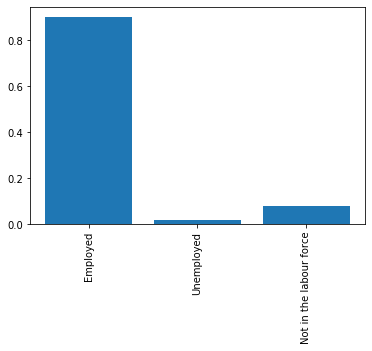

In [67]:
plt.bar(range(len(x)), x.pct)
plt.xticks(range(len(x)), labels=x.feature_desc, rotation=90)
plt.show()

In [120]:
ex_postal_codes = [x.postal_code for x in pccf_joined.where("da = 35204894").select('postal_code').distinct().collect()]

In [122]:
",".join(ex_postal_codes)

'M5V3K3,M5V0B5,M5V2J6,M5V2V1,M5V2P6,M5V1M7,M5V2L5,M5V2V5,M5V2L9,M5V1L9,M5V1K4,M5V3H5,M5V1S9,M5V1S4,M5V1E3,M5V0M8,M5V0M9,M5V1E1,M5V0L5,M5V2M7,M5V0G9,M5V2N2,M5V1H6,M5V2L2,M5V0L6,M5V0K8,M5V1T4,M5V2Z4,M5V2P9,M5V3T2,M5V3M4,M5V2J3,M5V2H8,M5V3S4,M5V2J4,M5V2V4,M5V1M1,M5V1N6,M5V0H1,M5V1S6,M5V1P5,M5V1L8,M5V2T8,M5V2M6,M5V3C1,M5V1T1,M5V1S5,M5V1M6,M5V2M9,M5V0A8,M5V2N3,M5V3M7,M5V2M1,M5V1M5,M5V2V8,M5V1P1,M5V0H7,M5V1S1,M5V0N7,M5V0H6,M5V1M3,M5V0N8,M5V1L7,M5V2N7'

# TODO
Other attributes still to add

In [ ]:
### Low-income
# Multiple measures...
# - In low income based on the Low-income measure, after tax (LIM-AT) (#852) -- added
# - In low income based on the Low-income cut-offs, after tax (LICO-AT) (#862)
#
# Q: which one to use?
# Q: should we include %?

In [163]:
# Total population, density
parse_features(g, [1, 6, 7, 58, 73], 'overall stats')

,da,feature_desc,feature_num,sex,count,feature
0,10010165,"Population, 2016",1,total,506.00,overall stats
1,10010165,Population density per square kilometre,6,total,1326.30,overall stats
2,10010165,Land area in square kilometres,7,total,0.38,overall stats
3,10010165,Average household size,58,total,2.30,overall stats
4,10010165,Average size of census families,73,total,2.60,overall stats


In [164]:
# Age
parse_features(g, [39, 40], 'age', alt_feature_names= ['Average', 'Median'])

,da,feature_desc,feature_num,sex,count,feature
0,10010165,Average,39,total,44.4,age
1,10010165,Median,40,total,48.6,age
2,10010165,Average,39,male,42.8,age
3,10010165,Median,40,male,47.5,age
4,10010165,Average,39,female,45.9,age
5,10010165,Median,40,female,50.1,age


In [165]:
# income
parse_features(g, [663, 671, 674, 682], name='income')

,da,feature_desc,feature_num,sex,count,feature
0,10010165,Median total income in 2015 among recipients ($),663,total,40192.0,income
1,10010165,Median employment income in 2015 among recipients ($),671,total,34208.0,income
2,10010165,Average total income in 2015 among recipients ($),674,total,53465.0,income
3,10010165,Average employment income in 2015 among recipients ($),682,total,48577.0,income
4,10010165,Median total income in 2015 among recipients ($),663,male,47744.0,income
5,10010165,Median employment income in 2015 among recipients ($),671,male,42176.0,income
6,10010165,Average total income in 2015 among recipients ($),674,male,70919.0,income
7,10010165,Average employment income in 2015 among recipients ($),682,male,62413.0,income
8,10010165,Median total income in 2015 among recipients ($),663,female,35883.0,income
9,10010165,Median employment income in 2015 among recipients ($),671,female,27904.0,income


In [172]:
### HOUSEHOLD inome
parse_features(g, [741, 742, 744, 745, 747, 748, 751, 754, 757], name='household income')

,da,feature_desc,feature_num,sex,count,feature
0,10010165,Total - Income statistics in 2015 for private households by household size - 100% data,741,total,210.0,household income
1,10010165,Median total income of households in 2015 ($),742,total,83072.0,household income
2,10010165,Total - Income statistics in 2015 for one-person private households - 100% data,744,total,55.0,household income
3,10010165,Median total income of one-person households in 2015 ($),745,total,36480.0,household income
4,10010165,Total - Income statistics in 2015 for two-or-more-person private households - 100% data,747,total,155.0,household income
5,10010165,Median total income of two-or-more-person households in 2015 ($),748,total,107264.0,household income
6,10010165,Average total income of households in 2015 ($),751,total,107600.0,household income
7,10010165,Average total income of one-person households in 2015 ($),754,total,40810.0,household income
8,10010165,Average total income of two-or-more-person households in 2015 ($),757,total,128755.0,household income


# Household

,da,feature_desc,feature_num,sex,count,feature
0,10010165,Single-detached house,42,total,110.0,dwelling
1,10010165,Apartment in a building that has five or more storeys,43,total,0.0,dwelling
2,10010165,Other attached dwelling,44,total,105.0,dwelling
3,10010165,Movable dwelling,50,total,0.0,dwelling


,da,feature_desc,feature_num,sex,count,feature,pct
0,10010165,1 person,52,total,60.0,household size,0.272727
1,10010165,2 persons,53,total,75.0,household size,0.340909
2,10010165,3 persons,54,total,40.0,household size,0.181818
3,10010165,4 persons,55,total,30.0,household size,0.136364
4,10010165,5 or more persons,56,total,15.0,household size,0.068182


,da,feature_desc,feature_num,sex,count,feature,pct
0,10010165,"Under $5,000",760,total,0.0,household income,0.000000
1,10010165,"$5,000 to $9,999",761,total,5.0,household income,0.023810
2,10010165,"$10,000 to $14,999",762,total,5.0,household income,0.023810
3,10010165,"$15,000 to $19,999",763,total,5.0,household income,0.023810
4,10010165,"$20,000 to $24,999",764,total,5.0,household income,0.023810
5,10010165,"$25,000 to $29,999",765,total,5.0,household income,0.023810
6,10010165,"$30,000 to $34,999",766,total,15.0,household income,0.071429
7,10010165,"$35,000 to $39,999",767,total,0.0,household income,0.000000
8,10010165,"$40,000 to $44,999",768,total,5.0,household income,0.023810
9,10010165,"$45,000 to $49,999",769,total,10.0,household income,0.047619


# Census family

In [157]:
# census family
# too many levels!!!
g[g.feature_num.isin(np.arange(74, 99))]

,da,feature_desc,feature_num,total,male,female
764053,10010165,Total number of census families in private households - 100% data,74,155.0,NaN,NaN
764054,10010165,Total couple families,75,130.0,NaN,NaN
764055,10010165,Married couples,76,120.0,NaN,NaN
764056,10010165,Common-law couples,77,15.0,NaN,NaN
764057,10010165,Total lone-parent families by sex of parent,78,20.0,NaN,NaN
764058,10010165,Female parent,79,15.0,NaN,NaN
764059,10010165,Male parent,80,5.0,NaN,NaN
764060,10010165,Total - Couple census families in private households - 100% data,81,135.0,NaN,NaN
764061,10010165,Couples without children,82,70.0,NaN,NaN
764062,10010165,Couples with children,83,65.0,NaN,NaN


In [160]:
g[g.feature_num.isin([74, 81, 87, 91])]

,da,feature_desc,feature_num,total,male,female
764053,10010165,Total number of census families in private households - 100% data,74,155.0,NaN,NaN
764060,10010165,Total - Couple census families in private households - 100% data,81,135.0,NaN,NaN
764066,10010165,Total - Lone-parent census families in private households - 100% data,87,20.0,NaN,NaN
764070,10010165,Total - Persons not in census families in private households - 100% data,91,95.0,35.0,60.0


,da,feature_desc,feature_num,sex,count,feature,pct
0,10010165,"Under $5,000",760,total,0.0,household income,0.000000
1,10010165,"$5,000 to $9,999",761,total,5.0,household income,0.023810
2,10010165,"$10,000 to $14,999",762,total,5.0,household income,0.023810
3,10010165,"$15,000 to $19,999",763,total,5.0,household income,0.023810
4,10010165,"$20,000 to $24,999",764,total,5.0,household income,0.023810
5,10010165,"$25,000 to $29,999",765,total,5.0,household income,0.023810
6,10010165,"$30,000 to $34,999",766,total,15.0,household income,0.071429
7,10010165,"$35,000 to $39,999",767,total,0.0,household income,0.000000
8,10010165,"$40,000 to $44,999",768,total,5.0,household income,0.023810
9,10010165,"$45,000 to $49,999",769,total,10.0,household income,0.047619


In [181]:
#* Could be in more than 1

# Ethnic origin
g[g.feature_num.isin([1338, 1339, 1343, 1353, 1427, 1448, 1473, 1541, 1607])]

,da,feature_desc,feature_num,total,male,female
765317,10010165,Total - Ethnic origin for the population in private households - 25% sample data,1338,540.0,245.0,295.0
765318,10010165,North American Aboriginal origins,1339,35.0,25.0,15.0
765322,10010165,Other North American origins,1343,215.0,100.0,115.0
765332,10010165,European origins,1353,385.0,170.0,215.0
765406,10010165,Caribbean origins,1427,0.0,0.0,0.0
765427,10010165,"Latin, Central and South American origins",1448,0.0,0.0,10.0
765452,10010165,African origins,1473,0.0,0.0,0.0
765520,10010165,Asian origins,1541,30.0,15.0,10.0
765586,10010165,Oceania origins,1607,0.0,0.0,0.0


In [185]:
# ethnic origin
ethnicorigin = parse_features(g, [1339, 1343, 1353, 1427, 1448, 1473, 1541, 1607], name='ethnic origin', agg=True)
ethnicorigin.loc[ethnicorigin.sex == 'total', 'count'].sum()

665.0